In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [11]:
def get_clean_data(filename):
    df = pd.read_csv('../capstone_data/Azimuth/clean/{}_clean.csv'.format(filename))
    df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('t',inplace=True)
    return df

In [12]:
df1 = get_clean_data('project_6d8c')
df2 = get_clean_data('project_1074')
df3 = get_clean_data('project_4229')
df4 = get_clean_data('project_5526')
df5 = get_clean_data('project_bc67')

In [13]:
dfs = [df1,df2,df3,df4,df5]
for df in dfs:
    print 'start: {}   end: {}'.format(df.index.min(),df.index.max())

start: 2016-10-13 10:30:00   end: 2017-01-29 06:30:00
start: 2017-05-27 00:00:00   end: 2017-08-11 12:00:00
start: 2016-05-18 00:00:00   end: 2017-02-28 23:55:00
start: 2016-02-15 16:00:00   end: 2017-08-14 15:15:00
start: 2016-10-15 00:00:00   end: 2017-01-08 00:30:00


In [14]:
def plot_all_data(df,columns):
    years = df['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = df[(df['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)

    fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, 5*len(y_m_combinations)))
    for ax, c in zip(axs,y_m_combinations):
        temp = df[(df['year'] == c[0]) & (df['month'] == c[1])]
        for col in columns:
            ax.plot(temp.index, temp[col])
        ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
        ax.fill_between(temp.index, 0,150, where=temp['relay_est'].values == 1, facecolor='red', alpha=0.5)
    plt.show()
    pass

In [15]:
def plot_time_frame(df,start,end,columns):
    '''
    Plot the timeseries for a given period of time
    PARAMETERS
    ------------
    df : Pandas DataFrame with DatetimeIndex
    start: string in format 'YYYY-MM-DD HH:MM:SS'
    end: string in format 'YYYY-MM-DD HH:MM:SS'
    columns: list of column names
    RETURNS
    -------
    None: plots the graphs
    '''
    temp = df.loc[(df.index>=start)&(df.index<end)]
    years = temp['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = temp[(temp['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)
    
    if len(y_m_combinations) ==1:
        temp2 = temp[(temp['year'] == y_m_combinations[0][0]) & (temp['month'] == y_m_combinations[0][1])]
        plt.figure(figsize=(14,4))
        for col in columns:
            plt.plot(temp2.index, temp2[col]/df[col].max())
        plt.title('timeseries for {}, {}'.format(y_m_combinations[0][0],y_m_combinations[0][0]))
        
    else:
        fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, len(y_m_combinations)*4))
        for ax, c in zip(axs,y_m_combinations):
            temp2 = temp[(temp['year'] == c[0]) & (temp['month'] == c[1])]
            for col in columns:
                ax.plot(temp2.index, temp2[col]/df[col].max())
            ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [16]:
df_34 = df3.merge(df4,how='outer', left_index=True, right_index=True)

In [17]:
df_34.dropna(inplace=True)

## Sum indication that there is correlation between outages. 

In [18]:
df_34.groupby('relay_est_x')['relay_est_y'].mean()

relay_est_x
0.0    0.177925
1.0    0.534934
Name: relay_est_y, dtype: float64

## Feature Engineering

Ideas:
- frequency of outages in the preceeding day
- Variance in the voltage of the last hour
- Deviation of the voltage mean.
- Amperes...


### Count of hours of outages in a preceeding timeframe

In [19]:
temp = pd.DataFrame(df2.relay_est)
result = pd.rolling_sum(temp.relay_est.shift(), window=24*12*7)
df2['week_hours_outage'] = result
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 17 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 2.7+ MB


/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2016,center=False).sum()
  


### Indicator for beginning of gen

In [20]:
df2['begin_gen'] = df2.relay_est.shift(1)
df2['begin_gen'] = df2['relay_est']-df2['begin_gen']
df2['begin_gen'] = df2['begin_gen'].apply(lambda x: 1 if x== 1 else 0)

In [21]:
temp = pd.DataFrame(df2.begin_gen)
result = pd.rolling_sum(temp.begin_gen.shift(), window=24*12*7)
df2['week_count_outage'] = result

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2016,center=False).sum()
  


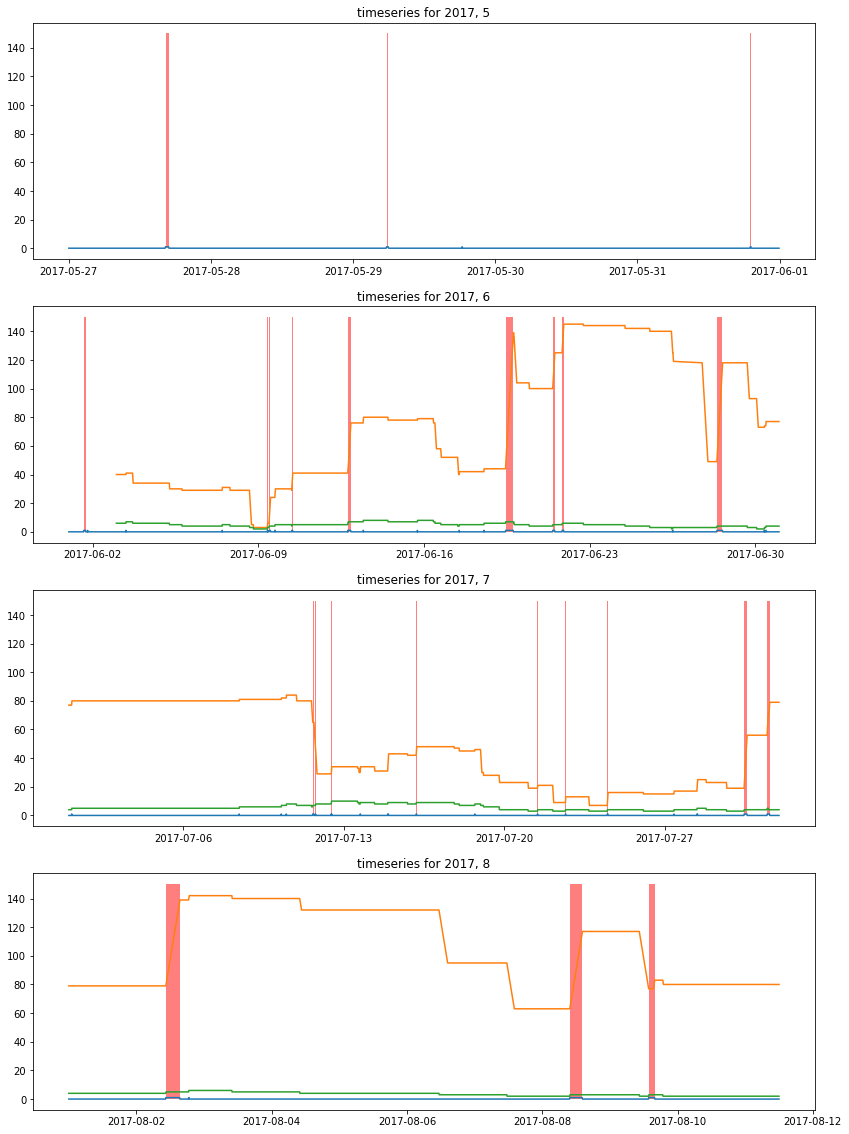

In [22]:
plot_all_data(df2,['relay_est','week_hours_outage','week_count_outage'])

In [23]:
df2[datetime(2017,8,2,10):datetime(2017,8,3)][['relay_est','week_hours_outage','week_count_outage','begin_gen']]

,relay_est,week_hours_outage,week_count_outage,begin_gen
t,,,,
2017-08-02 10:00:00,0,79.0,4.0,0
2017-08-02 10:05:00,0,79.0,4.0,0
2017-08-02 10:10:00,0,79.0,4.0,0
2017-08-02 10:15:00,0,79.0,4.0,0
2017-08-02 10:20:00,0,79.0,4.0,0
2017-08-02 10:25:00,1,79.0,4.0,1
2017-08-02 10:30:00,1,80.0,5.0,0
2017-08-02 10:35:00,1,81.0,5.0,0
2017-08-02 10:40:00,1,82.0,5.0,0


In [24]:
df2[['load_v1rms','load_v2rms','load_v3rms']].mean()

load_v1rms    229.563055
load_v2rms    233.243577
load_v3rms    234.158416
dtype: float64

In [25]:
temp = pd.DataFrame(df2.load_v1rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['v1rms_hr_std'] = result
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 20 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
begin_gen            19687 non-null int64
week_count_outage    17671 non-null float64
v1rms_hr_std         19654 non-null f

In [26]:
temp = pd.DataFrame(df2.load_v2rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['v2rms_hr_std'] = result
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 21 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
begin_gen            19687 non-null int64
week_count_outage    17671 non-null float64
v1rms_hr_std         19654 non-null f

In [27]:
temp = pd.DataFrame(df2.load_v3rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['v3rms_hr_std'] = result
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 22 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
begin_gen            19687 non-null int64
week_count_outage    17671 non-null float64
v1rms_hr_std         19654 non-null f

In [28]:
temp = pd.DataFrame(df2.load_i1rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['i1rms_hr_std'] = result
temp = pd.DataFrame(df2.load_i2rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['i2rms_hr_std'] = result
temp = pd.DataFrame(df2.laod_i3rms.shift(1))
result = temp.rolling('H',min_periods=5).std()
df2['i3rms_hr_std'] = result

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 25 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
begin_gen            19687 non-null int64
week_count_outage    17671 non-null float64
v1rms_hr_std         19654 non-null f

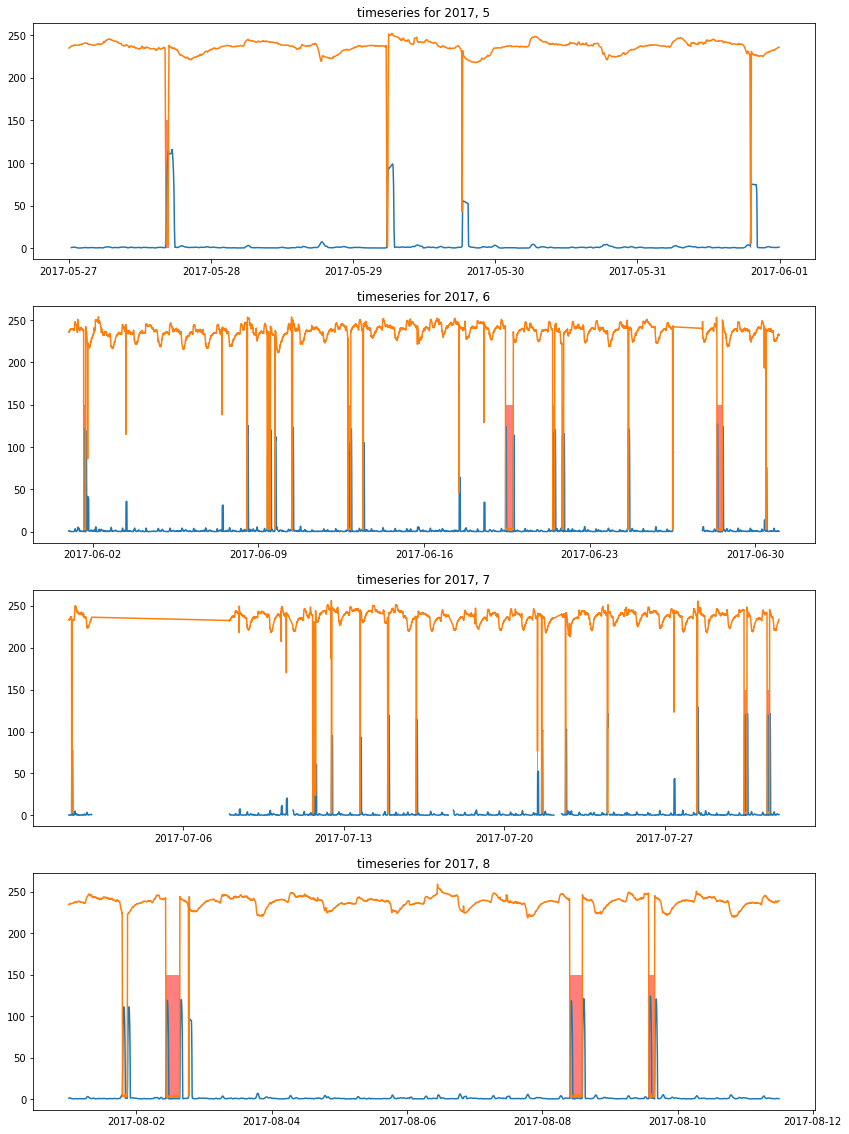

In [30]:
plot_all_data(df2,['v1rms_hr_std','load_v1rms'])

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19687 entries, 2017-05-27 00:00:00 to 2017-08-11 12:00:00
Data columns (total 25 columns):
project_id           19687 non-null object
relay                19687 non-null float64
load_v1rms           19687 non-null float64
load_v2rms           19687 non-null float64
load_v3rms           19687 non-null float64
load_i1rms           19687 non-null float64
load_i2rms           19687 non-null float64
laod_i3rms           19687 non-null float64
year                 19687 non-null int64
month                19687 non-null int64
day                  19687 non-null int64
dayofweek            19687 non-null int64
hour                 19687 non-null int64
relay_est            19687 non-null int64
t_diff               19675 non-null float64
data_issue           19687 non-null int64
week_hours_outage    17671 non-null float64
begin_gen            19687 non-null int64
week_count_outage    17671 non-null float64
v1rms_hr_std         19654 non-null f

In [32]:
df2.groupby('begin_gen').mean()

,relay,load_v1rms,load_v2rms,load_v3rms,load_i1rms,load_i2rms,laod_i3rms,year,month,day,dayofweek,hour,relay_est,t_diff,data_issue,week_hours_outage,week_count_outage,v1rms_hr_std,v2rms_hr_std,v3rms_hr_std,i1rms_hr_std,i2rms_hr_std,i3rms_hr_std
begin_gen,,,,,,,,,,,,,,,,,,,,,,,
0,0.028857,229.816054,233.501710,234.417368,96.855930,86.968216,85.117639,2017.0,6.586690,15.968939,3.073273,11.429452,0.029788,1.0,0.0,64.812695,5.002156,4.415599,4.412079,4.390162,16.713034,15.503863,10.928552
1,0.526241,126.049585,127.629295,128.209277,78.415284,74.229495,69.874303,2017.0,6.479167,15.979167,2.604167,12.312500,1.000000,1.0,0.0,51.904762,4.785714,3.472637,3.426792,3.392866,18.289407,17.094242,11.788790


In [33]:
df2.groupby('begin_gen').max()

,project_id,relay,load_v1rms,load_v2rms,load_v3rms,load_i1rms,load_i2rms,laod_i3rms,year,month,day,dayofweek,hour,relay_est,t_diff,data_issue,week_hours_outage,week_count_outage,v1rms_hr_std,v2rms_hr_std,v3rms_hr_std,i1rms_hr_std,i2rms_hr_std,i3rms_hr_std
begin_gen,,,,,,,,,,,,,,,,,,,,,,,,
0,10742532-49d3-11e7-8d05-f23c91e2b423,1.0,259.229074,261.013741,261.741363,530.656618,539.524321,396.978118,2017,8,31,6,23,1,1.0,0,145.0,10.0,129.105962,130.095629,128.879167,139.107334,138.791232,98.391841
1,10742532-49d3-11e7-8d05-f23c91e2b423,1.0,233.205198,238.843053,240.710540,269.633529,307.258159,244.250946,2017,8,31,6,21,1,1.0,0,139.0,9.0,84.792569,86.238409,86.538889,137.996009,136.837765,98.944318


## Looking at total power:

In [36]:
df1 = get_clean_data('project_6d8c')
df2 = get_clean_data('project_1074')
df3 = get_clean_data('project_4229')
df4 = get_clean_data('project_5526')
df5 = get_clean_data('project_bc67')

In [37]:
for df in dfs:
    df['power_1'] = df['load_v1rms'] * df['load_i1rms']
    df['power_2'] = df['load_v2rms'] * df['load_i2rms']
    df['power_3'] = df['load_v3rms'] * df['laod_i3rms']
    df['power_all'] = df['power_1'] + df['power_2'] + df['power_3']

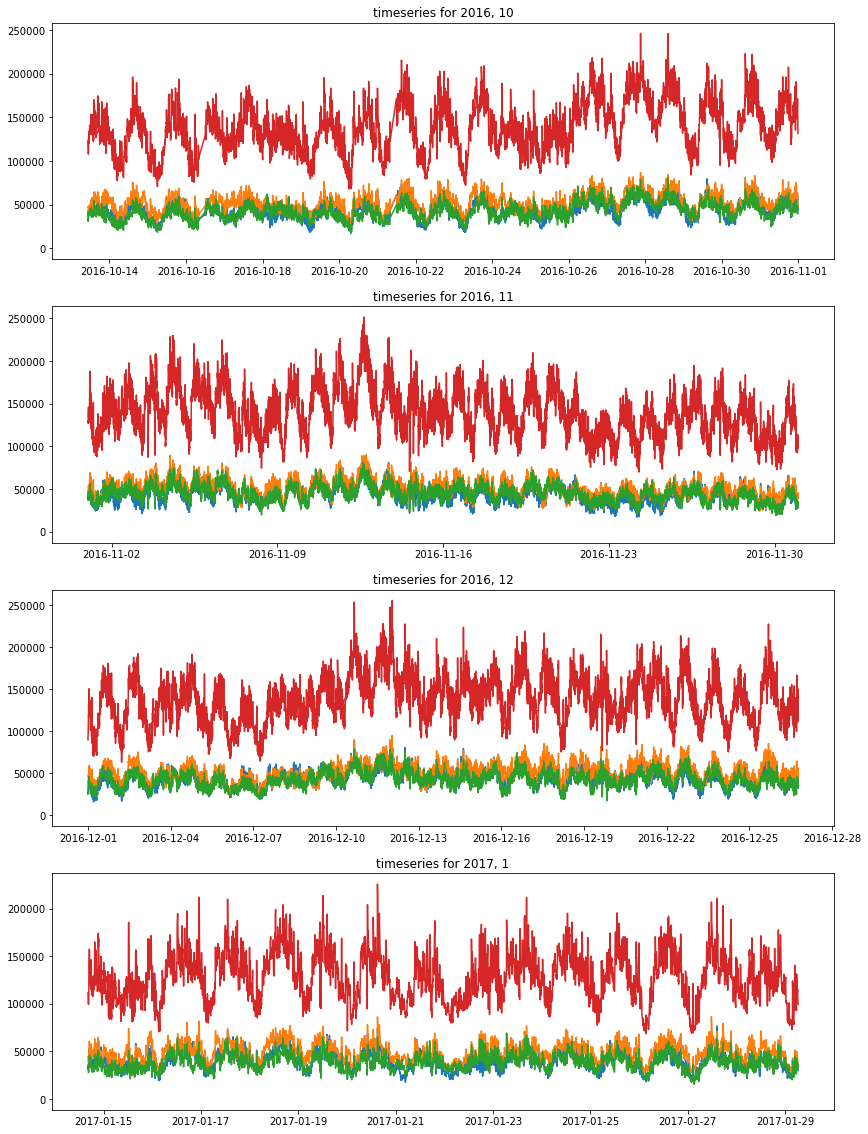

In [48]:
plot_all_data(dfs[0],['power_1','power_2','power_3','power_all'])
# plot_all_data(dfs[1],['power_1','power_2','power_3','power_all'])
# plot_all_data(dfs[2],['power_1','power_2','power_3','power_all'])
# plot_all_data(dfs[3],['power_1','power_2','power_3','power_all'])
# plot_all_data(dfs[4],['power_1','power_2','power_3'])
# plot_all_data(dfs[4],['load_i1rms','load_i2rms','laod_i3rms'])